In [ ]:
#Load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Test path is valid
!cd /content/drive/My\ Drive/datas; ls;

'186_Pirates of the Caribbean.csv'   231_Terminator.csv
 229_Surrogates.csv		     51_conan_the_barbarian.csv
 230_Swordfish.csv


In [ ]:
%%writefile setup.py

setup.py

Writing setup.py


In [ ]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

Writing setup.sh


In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install -v --no-cache-dir apex

!sh setup.sh

In [ ]:
# install libraries
!pip install transformers
!pip install simpletransformers

In [ ]:
# import libraries

from transformers import *
import tensorflow as tf 
import pandas as pd
import os

In [ ]:
# Check path
PATH='/content/drive/My Drive/datas/'
filenames=os.listdir(PATH)
print(filenames)

#load test
train_df=pd.read_csv(PATH+filenames[1], dtype={'sentence':str, 'label': int}, encoding='Windows-1252')
train_df.columns=['sentence', 'label']

print(filenames[0])
train_df[:10]

['186_Pirates of the Caribbean.csv', '231_Terminator.csv', '51_conan_the_barbarian.csv', '229_Surrogates.csv', '230_Swordfish.csv']
186_Pirates of the Caribbean.csv


,sentence,label
0,""" T E R M I N A T O R "" by",0
1,James Cameron,0
2,Registered WGAw,0
3,Fourth Draft,0
4,20.Apr.83,0
5,----------------------------------------------...,0
6,TERMINATOR,0
7,A1 TITLE SEQUENCE - SLITSCAN EFFECT ...,0
8,EXT,5
9,SCHOOLYARD,5


In [ ]:
# detect encode error
import chardet    
rawdata = open(PATH+filenames[1], 'rb').read()
result = chardet.detect(rawdata)
charenc = result['encoding']
print(charenc)

ascii


In [ ]:
train_dfs=[]

for i in range(len(filenames)):
  print('loading '+filenames[i])
  train_df=pd.read_csv(PATH+filenames[i], dtype={'sentence':str, 'label': int}, encoding = 'Windows-1252')
  train_df.columns=['sentence', 'label']
  train_dfs.append(train_df)

loading 186_Pirates of the Caribbean.csv
loading 231_Terminator.csv
loading 51_conan_the_barbarian.csv
loading 229_Surrogates.csv
loading 230_Swordfish.csv


In [ ]:
for i, item in enumerate(train_dfs[1]['label']):
   try:
      int(item)
   except ValueError:
      print('ERROR at index {}: {!r}'.format(i, item))

# **Create Model**

In [ ]:
from simpletransformers.classification import ClassificationModel

checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoint/'
bestmodel_path = '/content/drive/My Drive/Colab Notebooks/best_model/'
#pretrained_path = '/content/drive/My Drive/Colab Notebooks/best_model/checkpoint-12000/'
params = {
          'num_train_epochs': 1,
          'reprocess_input_data': True,
          'overwrite_output_dir': True,
          'output_dir': checkpoint_path,
          'learning_rate':4e-5,
          'save_model_every_epoch': True,
          'evaluate_during_training': True,
          "use_early_stopping": True,
          "early_stopping_patience": 3,
          "early_stopping_delta": 0,
          "early_stopping_metric": "eval_loss",
          "early_stopping_metric_minimize": True,
          }

# Create New TransformerModel with modified attributes.
model = ClassificationModel('bert', 'bert-large-cased', use_cuda=False, num_labels=8, args=params)
# create model with save point if you have.
# learn if you make checkpoint before.
#model = ClassificationModel('bert', pretrained_path, num_labels=8, args=params)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [ ]:
# Find errors
filenames

['186_Pirates of the Caribbean.csv',
 '231_Terminator.csv',
 '51_conan_the_barbarian.csv',
 '229_Surrogates.csv',
 '230_Swordfish.csv']

In [ ]:
# Train
#train_df=pd.concat([train_dfs[2], train_dfs[4]])
train_df=train_dfs[1]
print(len(train_df))
eval_df=train_dfs[0]
eval_df[:10]

4238


,sentence,label
0,FADE IN:,0
1,EXT.,5
2,CARIBBEAN SEA,5
3,DAY,6
4,"A gray, impenetrable wall of fog.",1
5,From somewhere comes the FAINT SOUND of a LITT...,1
6,YOUNG ELIZABETH,2
7,"Yo, ho, yo, ho, a pirate's life for me Yo, ho,...",3
8,"Suddenly a massive SHIP emerges from the grey,...",1
9,"It's a British dreadnought, the H.M.S.",1


In [ ]:
model.train_model(train_df, eval_df=eval_df)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
# Evaluate the model
eval_df=train_dfs[1]
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


{'acc': 0.9672015101462954,
 'eval_loss': 0.1420057223279486,
 'mcc': 0.9511344947191005}

In [ ]:
# get true/predict data value of labels.
predict_tag = model.predict(eval_df['sentence'])
predict_tag = predict_tag[0]
real_tag = eval_df['label'].to_numpy()

# make confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(real_tag, predict_tag)

In [ ]:
# function that show the confusion matrix
import numpy as np
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.rcParams.update({'font.size': 12})
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:.1f}%".format(cm[i, j]*100),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",                         
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:.3f}; misclass={:.3f}'.format(accuracy, misclass))
    plt.show()

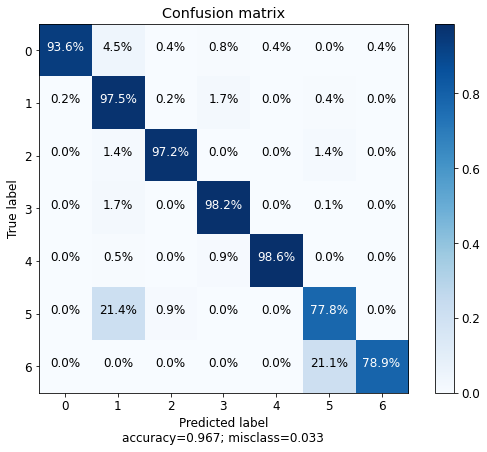

In [ ]:
plot_confusion_matrix(cm)

### **TEST**

In [ ]:
predictions, raw_outputs = model.predict(['JOHN'])
print(predictions)#, raw_outputs

predictions, raw_outputs = model.predict(['No thanks, I\'m not staying long.'])
print(predictions)#, raw_outputs


[2]



[3]
